In [1]:
%load_ext autoreload
%autoreload 2
exec(open('init_notebook.py').read())
from matplotlib import pyplot as plt
from highD.HighD import HighD
from highD.Filter import Filter
from highD.Plot import Plot
from highD.Visualizer import GIF
from highD.helper import *

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

current working dirC:\Users\abjawad\Documents\GitHub\cogMod-driver-behavior-model\highd_tools


In [2]:
cogmod_file_name = "2023-05-18-19-41-15---1.csv"
cogmod_file_path = os.path.join(COGMOD_LOGS, cogmod_file_name)
cogmod_df = pd.read_csv(cogmod_file_path)

other_cogmod_file_name = "2023-05-18-20-06-56---1.csv"
cogmod_file_path = os.path.join(COGMOD_LOGS, other_cogmod_file_name)
other_cogmod_df = pd.read_csv(cogmod_file_path)
print(other_cogmod_df.columns)
other_cogmod_df.head()

Index(['scenario_id', 'exec_num', 'frame', 'scenario_status', 'ego_id', 'c_x',
       'c_y', 'c_speed', 'c_acceleration', 'c_steer', 'c_throttle', 'c_brake',
       'perceived_c_x', 'perceived_c_y', 'perceived_c_speed', 'gaze_direction',
       'preceding_id', 'a_x', 'a_y', 'a_speed'],
      dtype='object')


,scenario_id,exec_num,frame,scenario_status,ego_id,c_x,c_y,c_speed,c_acceleration,c_steer,c_throttle,c_brake,perceived_c_x,perceived_c_y,perceived_c_speed,gaze_direction,preceding_id,a_x,a_y,a_speed
0,1,10,5,ScenarioState.PENDING,15.0,-292.304047,19.415213,0.784,0.784,0.0,0.0,0.0,0.0,0.0,0.0,GazeDirection.CENTER,12.0,72.980003,0.87,36.020004
1,1,10,6,ScenarioState.PENDING,15.0,-292.304047,19.415213,1.176,1.176,0.0,0.0,0.0,0.0,0.0,0.0,GazeDirection.CENTER,12.0,72.980003,0.87,36.020004
2,1,10,7,ScenarioState.PENDING,15.0,-292.304047,19.415213,1.568,1.568,0.0,0.0,0.0,0.0,0.0,0.0,GazeDirection.CENTER,12.0,72.980003,0.87,36.020004
3,1,10,8,ScenarioState.PENDING,15.0,-292.304047,19.415213,1.960,1.960,0.0,0.0,0.0,0.0,0.0,0.0,GazeDirection.CENTER,12.0,72.980003,0.87,36.020004
4,1,10,9,ScenarioState.PENDING,15.0,-292.304047,19.415213,2.352,2.352,0.0,0.0,0.0,0.0,0.0,0.0,GazeDirection.CENTER,12.0,72.980003,0.87,36.020004


In [3]:

def plot_all_executions(dataframe):
    # Assuming df is your DataFrame
    df = dataframe.copy()
    # group by exec_num
    grouped = df.groupby('exec_num')

    fig, axs = plt.subplots(1, 6, figsize=(30, 5))  # Increase number of subplots to 6

    # iterate over each group
    for name, group in grouped:
        # change frame number for each group to start at 1
        group['frame'] = group['frame'] - group['frame'].min() + 1
        
        group = group[group['scenario_status'] != 'ScenarioState.PENDING']
        
        axs[0].plot(group['frame'], group['a_speed'], label=f'a_speed {name}')
        axs[0].plot(group['frame'], group['c_speed'], label=f'c_speed {name}')

        axs[1].plot(group['frame'], group['c_steer'], label=f'exec_num {name}')
        axs[2].plot(group['frame'], group['c_throttle'], label=f'exec_num {name}')
        axs[3].plot(group['frame'], group['c_brake'], label=f'exec_num {name}')

        # plot gaze_direction
        group['gaze_direction'].value_counts().plot(kind='bar', ax=axs[4], label=f'exec_num {name}')

        # plot perceived_c_x, perceived_c_y, a_x, a_y in the sixth plot
        axs[5].plot(group['frame'], group['perceived_c_x'], label=f'perceived_c_x {name}')
        axs[5].plot(group['frame'], group['perceived_c_y'], label=f'perceived_c_y {name}')
        axs[5].plot(group['frame'], group['a_x'], label=f'a_x {name}')
        axs[5].plot(group['frame'], group['a_y'], label=f'a_y {name}')

    # Set labels and titles
    axs[0].set_xlabel('Frame')
    axs[0].set_ylabel('Speed')
    axs[0].set_title('Cogmod Speed across all Executions')
    # axs[0].legend()

    axs[1].set_xlabel('Frame')
    axs[1].set_ylabel('Steer')
    axs[1].set_title('Cogmod Steer across all Executions')
    # axs[1].legend()

    axs[2].set_xlabel('Frame')
    axs[2].set_ylabel('Throttle')
    axs[2].set_title('Cogmod Throttle across all Executions')
    # axs[2].legend()

    axs[3].set_xlabel('Frame')
    axs[3].set_ylabel('Brake')
    axs[3].set_title('Cogmod Brake across all Executions')
    # axs[3].legend()

    axs[4].set_xlabel('Gaze Direction')
    axs[4].set_ylabel('Count')
    axs[4].set_title('Gaze Direction across all Executions')
    # axs[4].legend()

    # set labels and title for the new plot
    axs[5].set_xlabel('Frame')
    axs[5].set_ylabel('Values')
    axs[5].set_title('Perceived and Actual Values across all Executions')
    # axs[5].legend()

    plt.tight_layout()
    plt.show()



def scatter_values(df):
    # group by exec_num
    grouped = df.groupby('exec_num')

    for name, group in grouped:
        fig, axs = plt.subplots(1, 3, figsize=(20, 6))

        # change frame number for each group to start at 1
        group['frame'] = group['frame'] - group['frame'].min() + 1
        group = group[group['scenario_status'] != 'ScenarioState.PENDING']

        # Create a new DataFrame for calculations
        calc_df = pd.DataFrame()
        calc_df['frame'] = group['frame']
        calc_df['perceived_distance'] = np.sqrt((group['c_x'] - group['perceived_c_x'])**2 
                                                + (group['c_y'] - group['perceived_c_y'])**2)
        calc_df['actual_distance'] = np.sqrt((group['c_x'] - group['a_x'])**2 
                                              + (group['c_y'] - group['a_y'])**2)

        # scatter plot perceived_distance and actual_distance
        axs[0].plot(calc_df['frame'], calc_df['perceived_distance'], label='Perceived Distance')
        axs[0].plot(calc_df['frame'], calc_df['actual_distance'], label='Actual Distance')

        axs[0].set_xlabel('Frame')
        axs[0].set_ylabel('Distance')
        axs[0].set_title(f'Perceived and Actual Distances for exec_num {name}')
        axs[0].legend()

        # plot gaze_direction
        group['gaze_direction'].value_counts().plot(kind='bar', ax=axs[1], label=f'exec_num {name}')

        axs[1].set_xlabel('Gaze Direction')
        axs[1].set_ylabel('Count')
        axs[1].set_title('Gaze Direction across all Executions')
        
        
        # plot gaze_direction
        axs[2].plot(group['frame'], group['perceived_c_speed'], label='Perceived Velocity')
        axs[2].plot(group['frame'], group['a_speed'], label='Actual Velocity')

        axs[2].set_xlabel('Speed')
        axs[2].set_ylabel('Count')
        axs[2].set_title('Perceived speed and actual speed across all Executions')
        axs[2].legend()
        
        

        plt.tight_layout()
        plt.show()

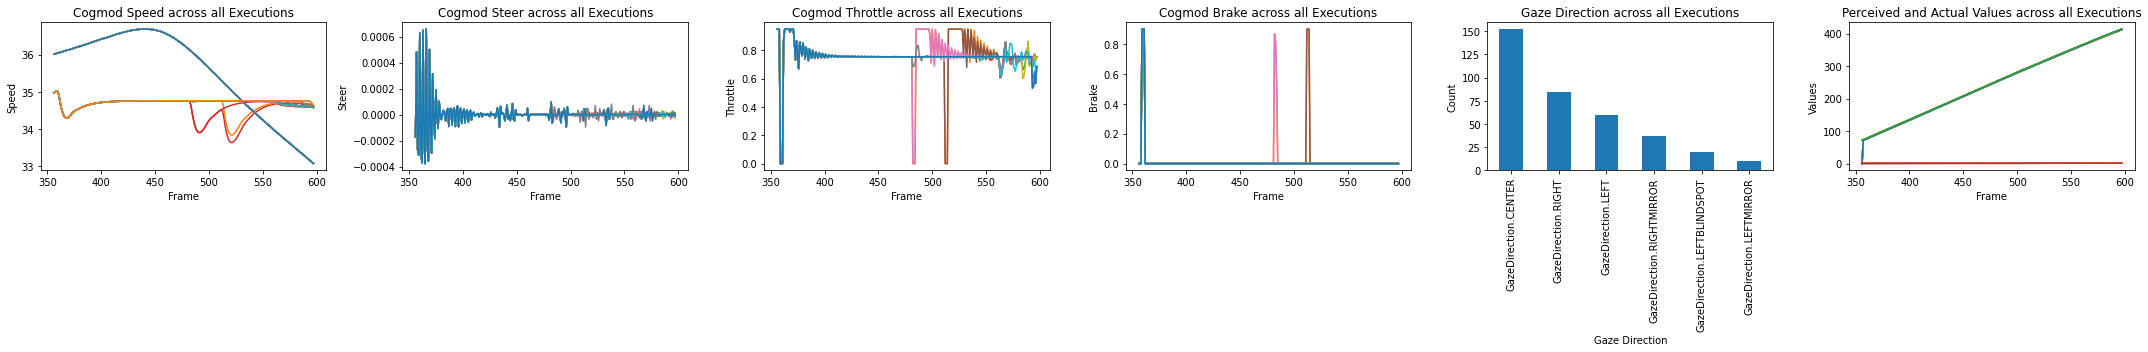

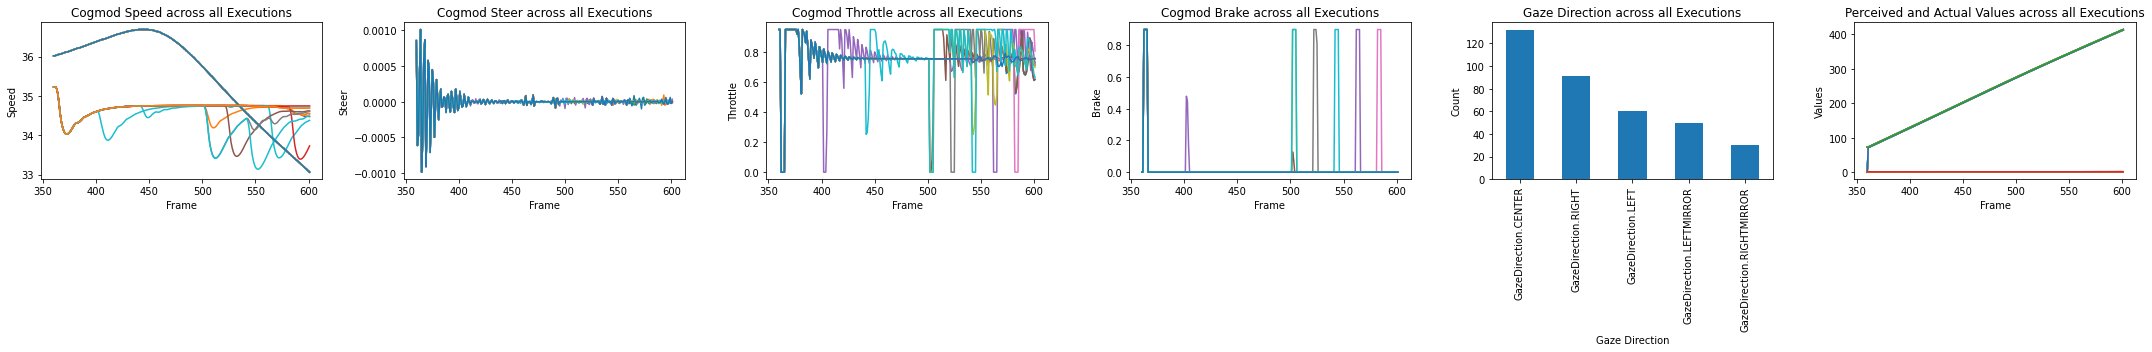

In [4]:
plot_all_executions(cogmod_df)
plot_all_executions(other_cogmod_df)

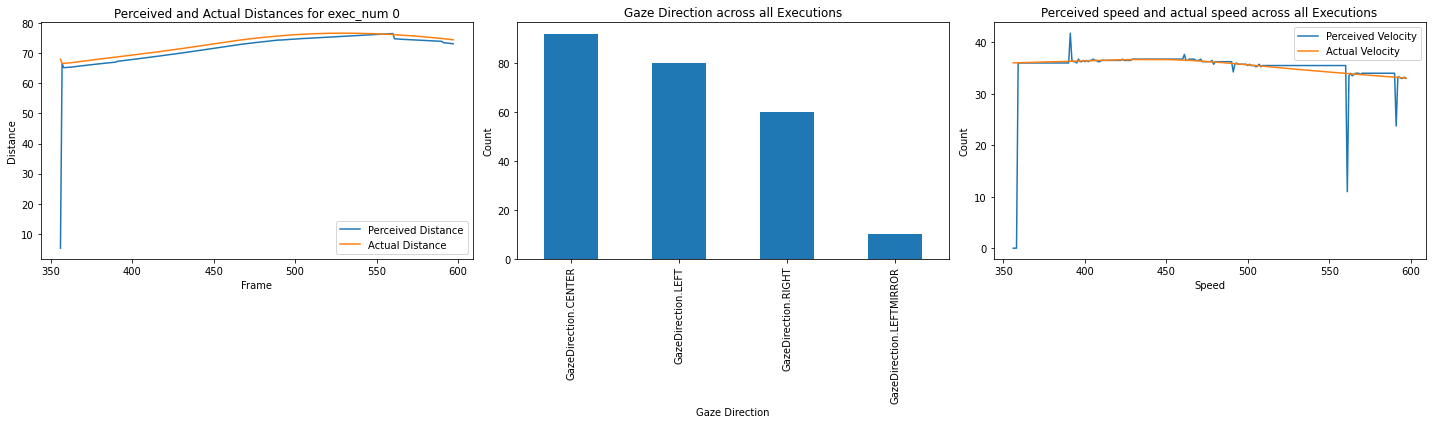

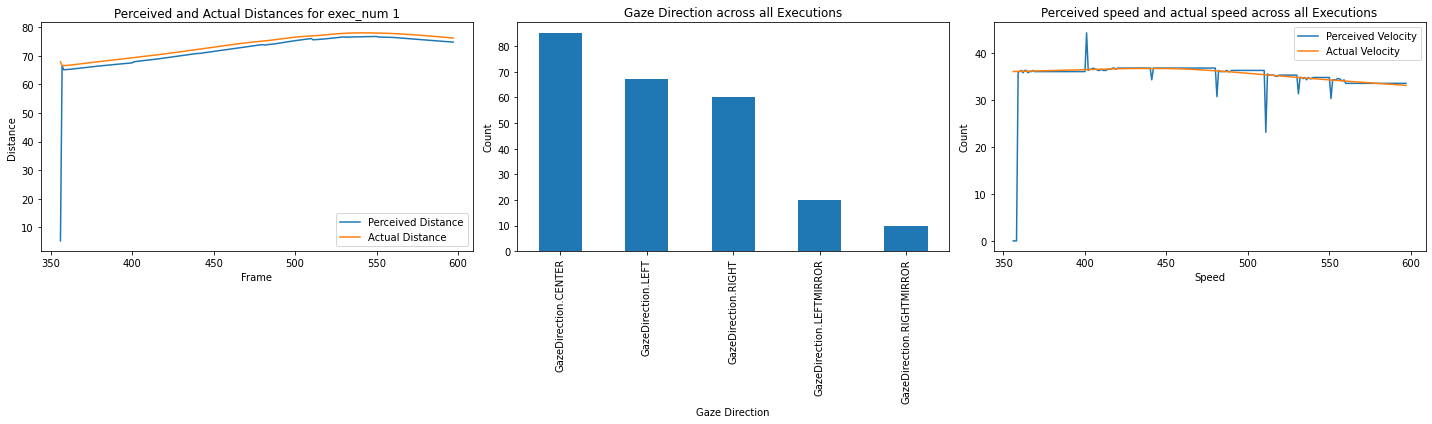

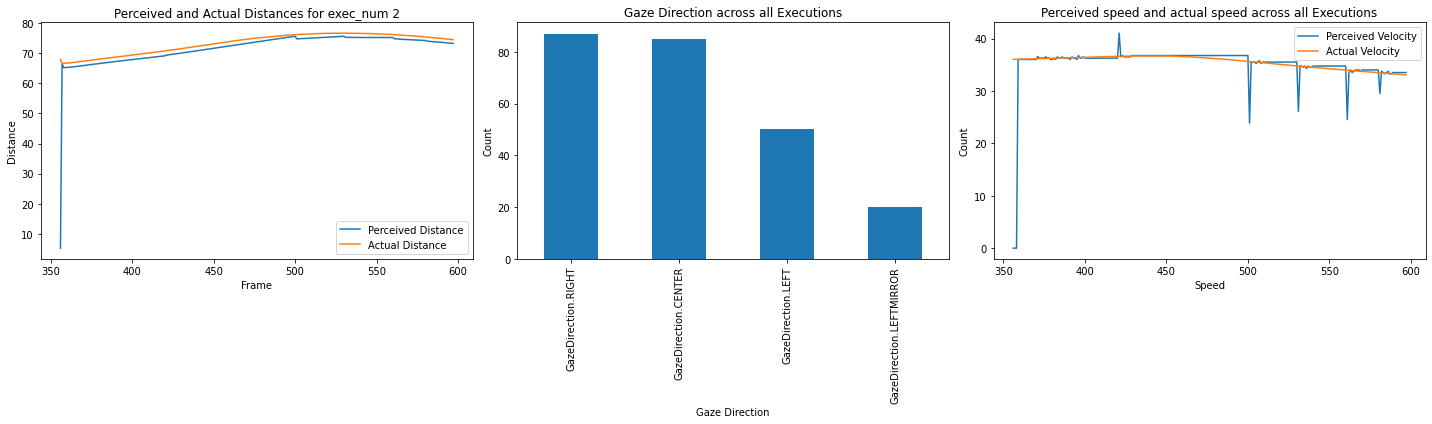

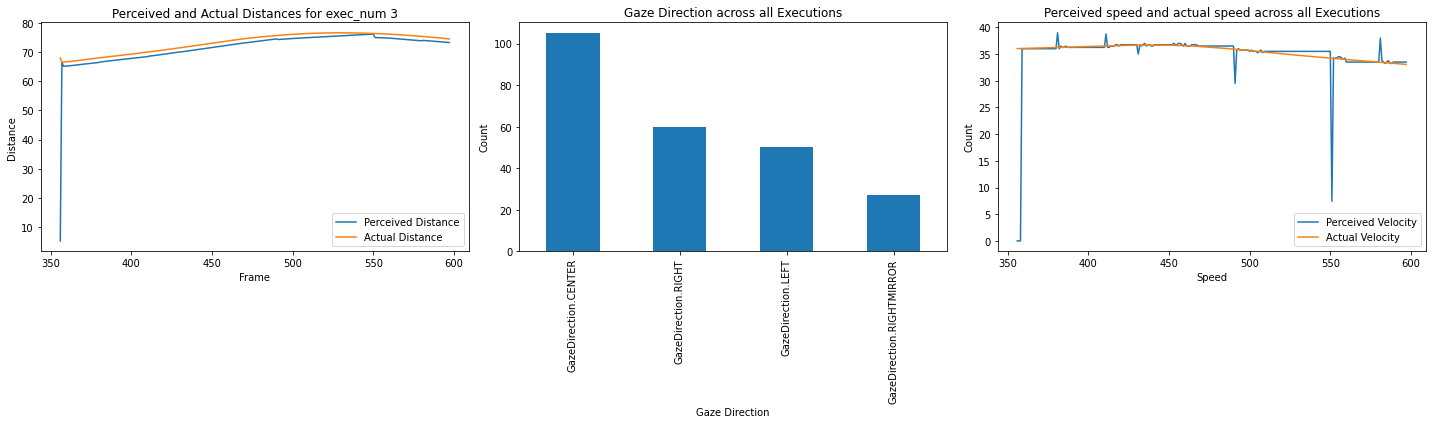

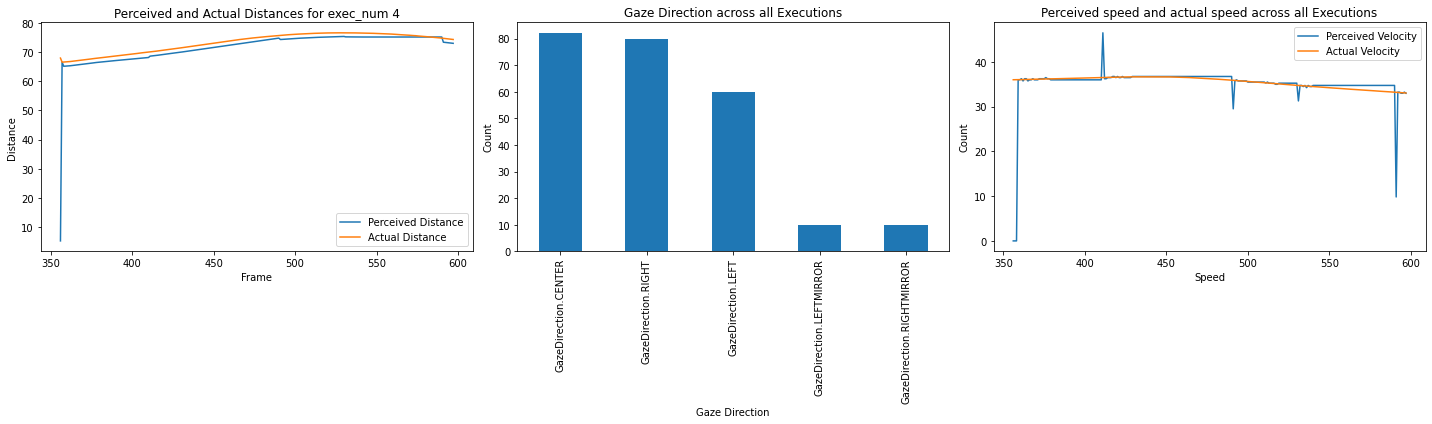

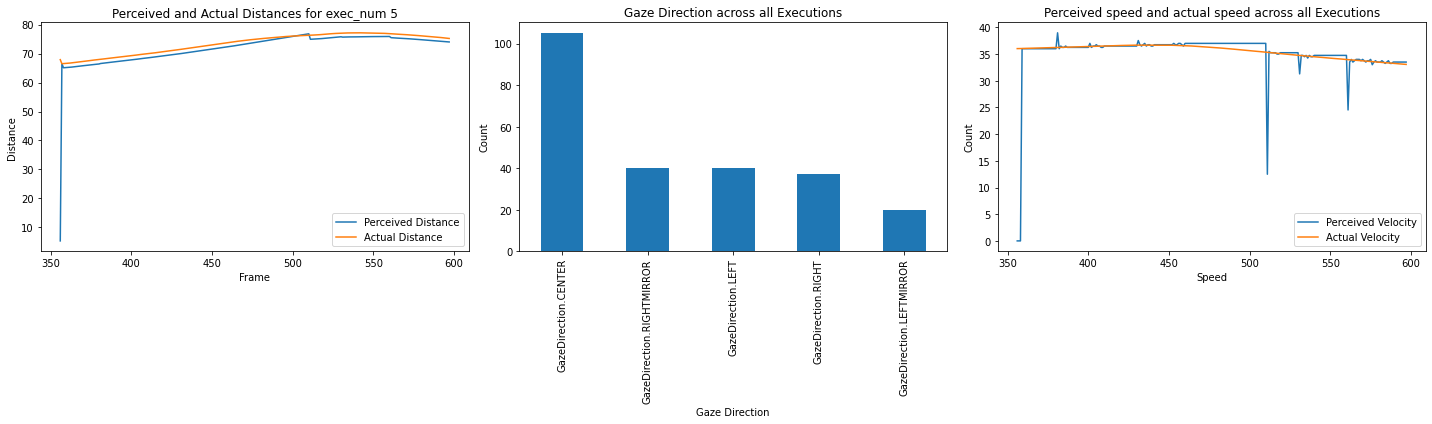

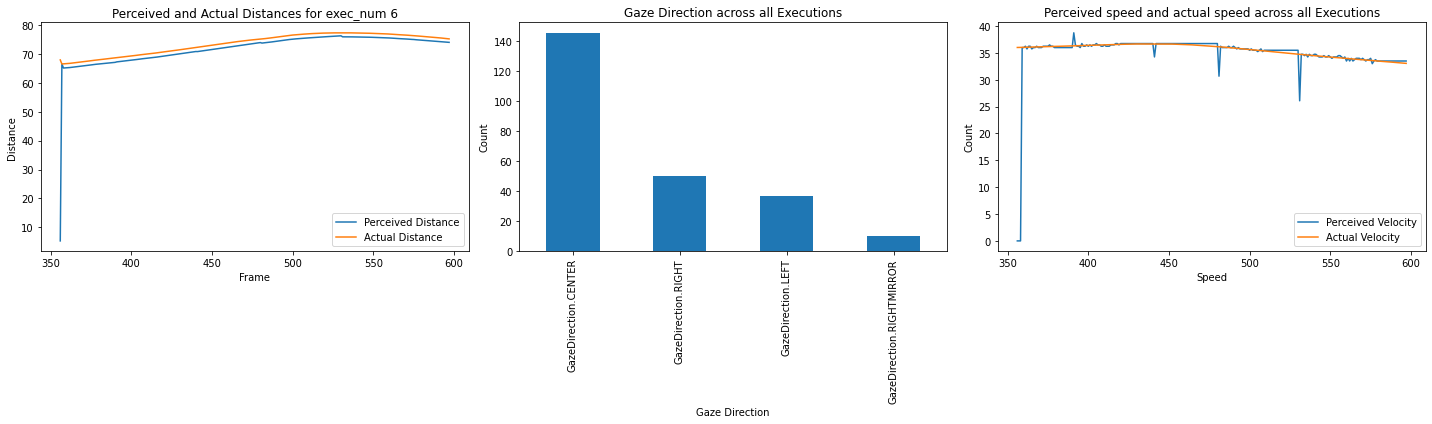

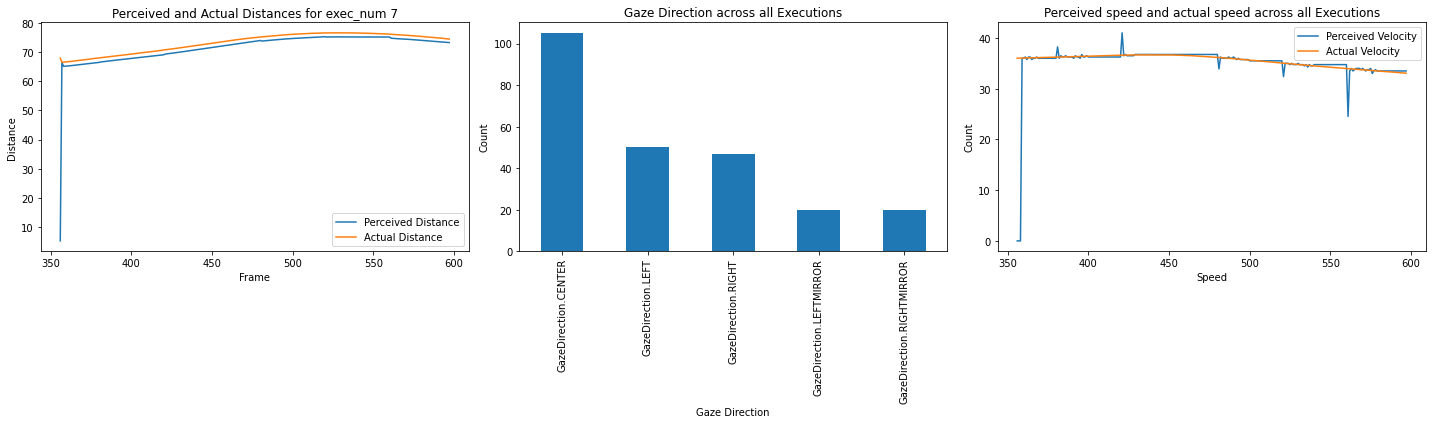

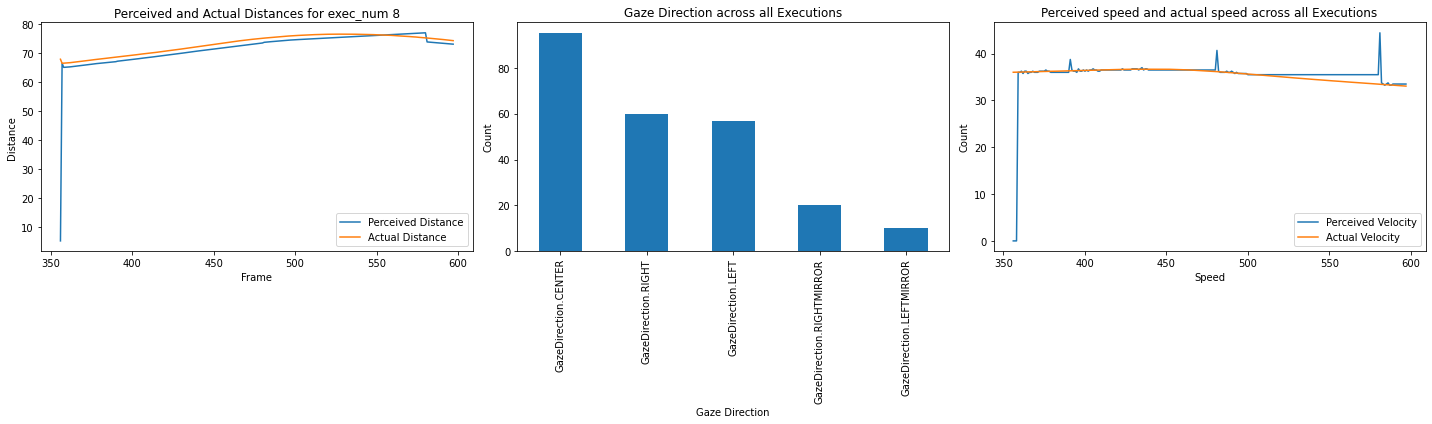

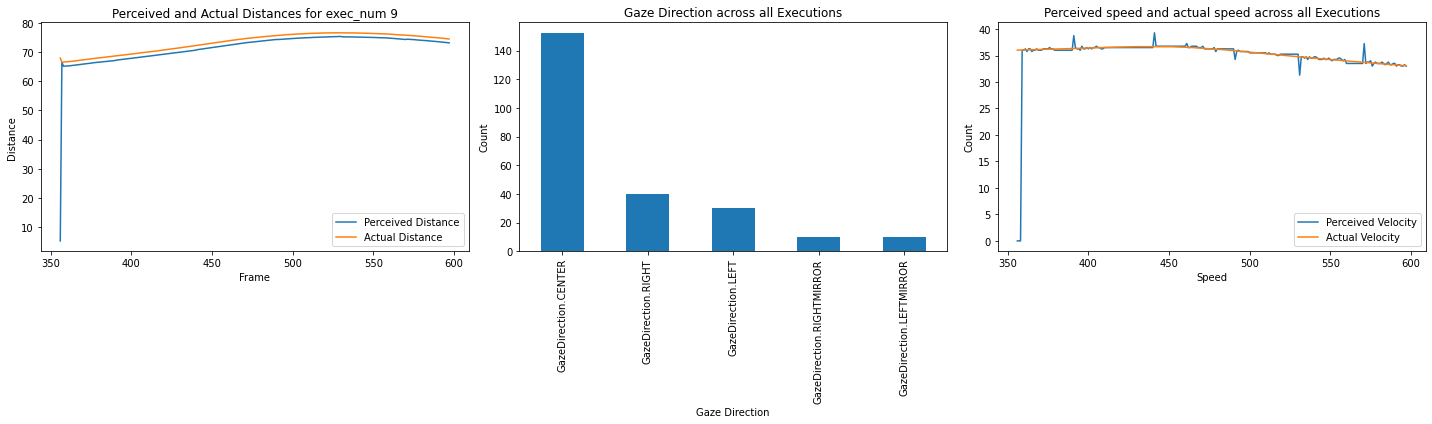

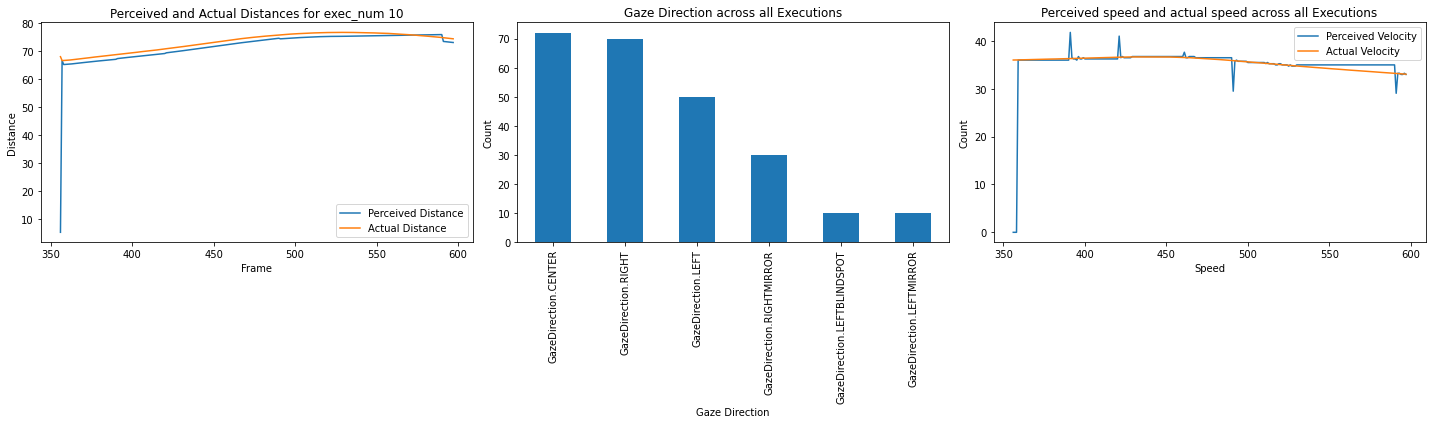

In [5]:
scatter_values(cogmod_df)

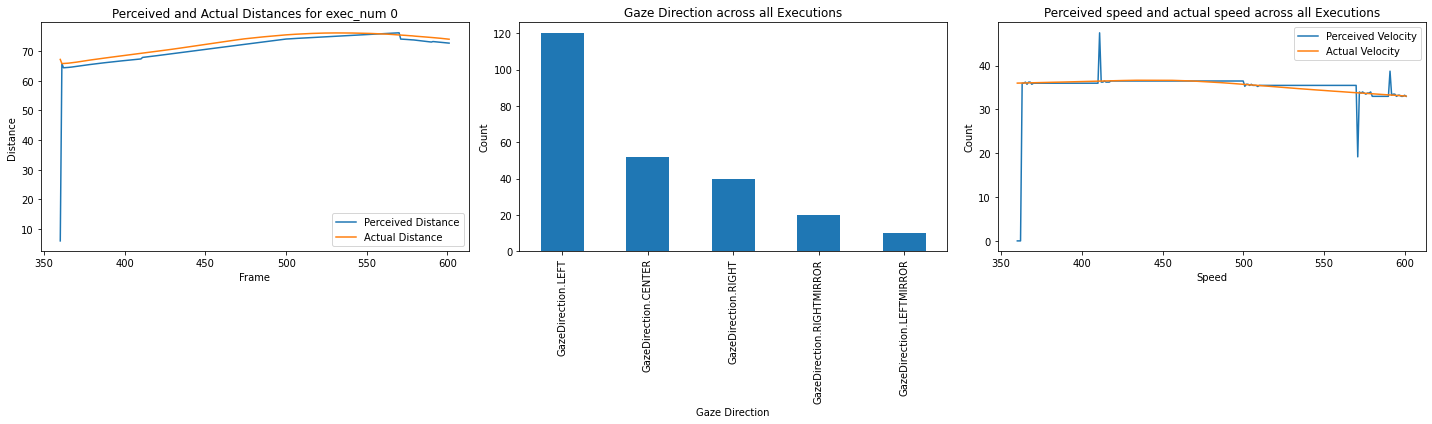

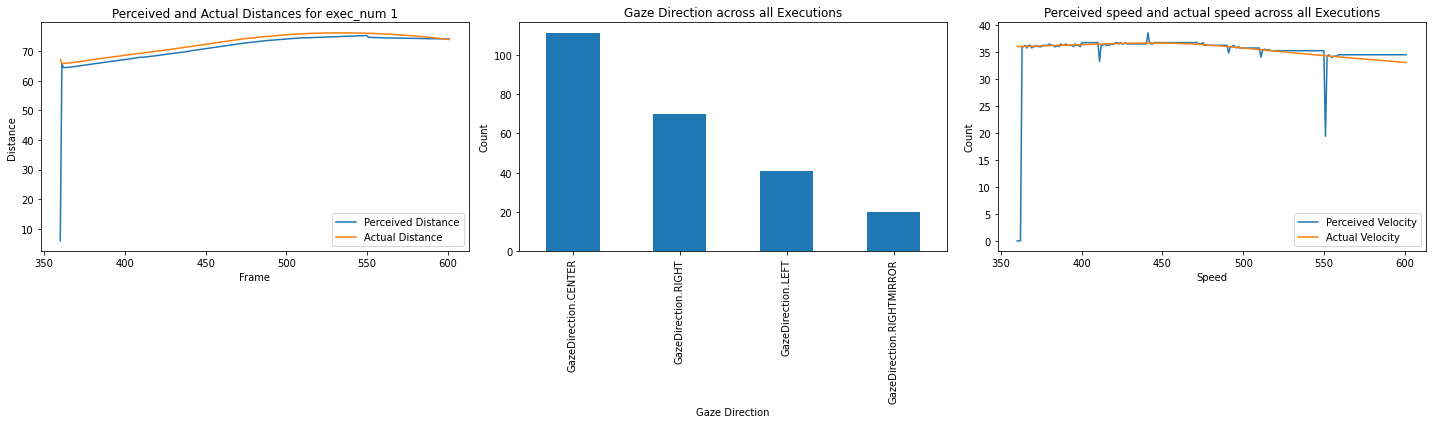

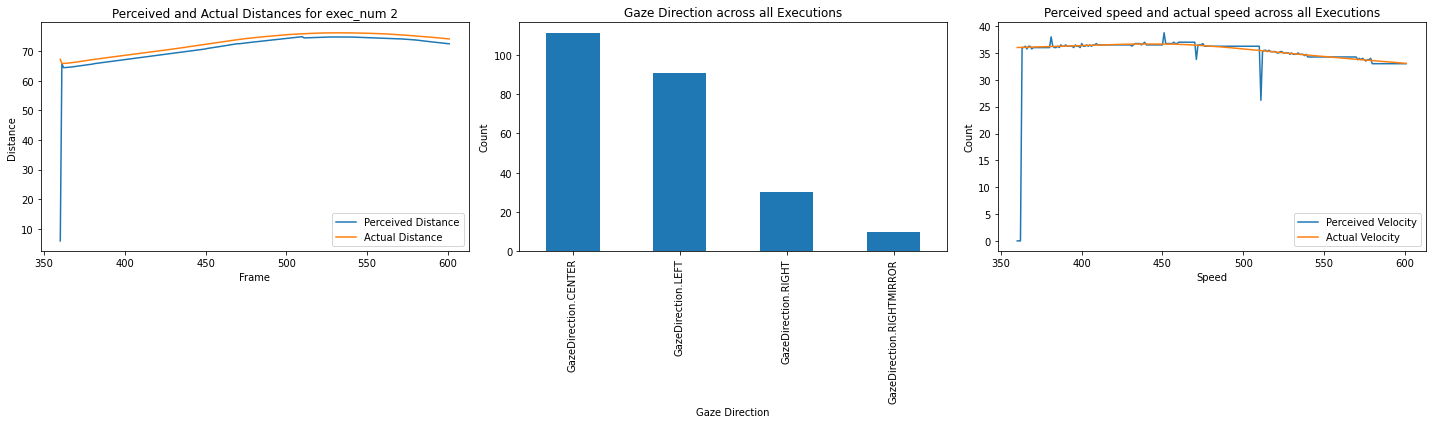

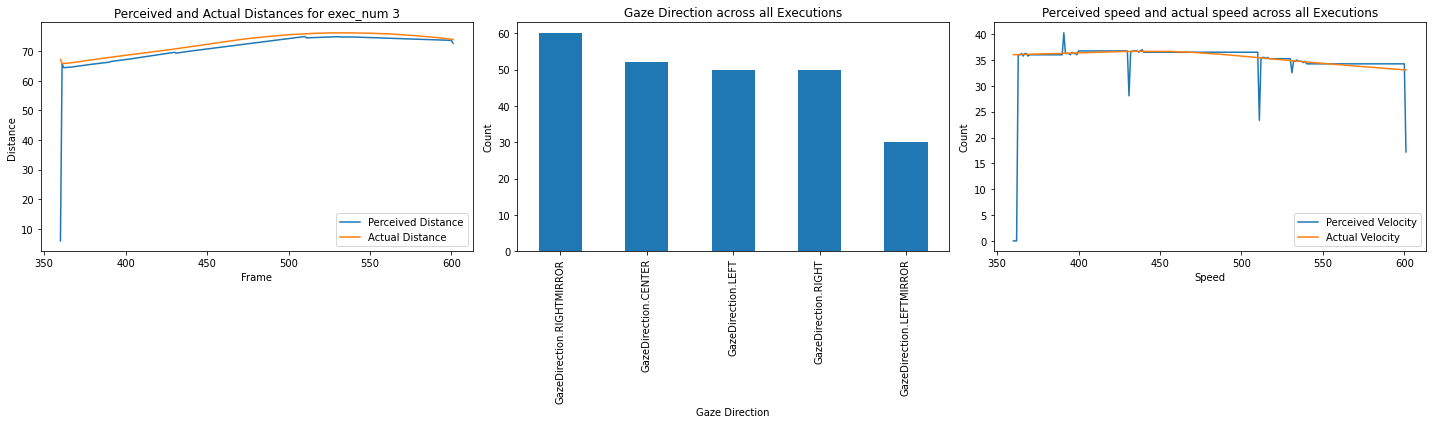

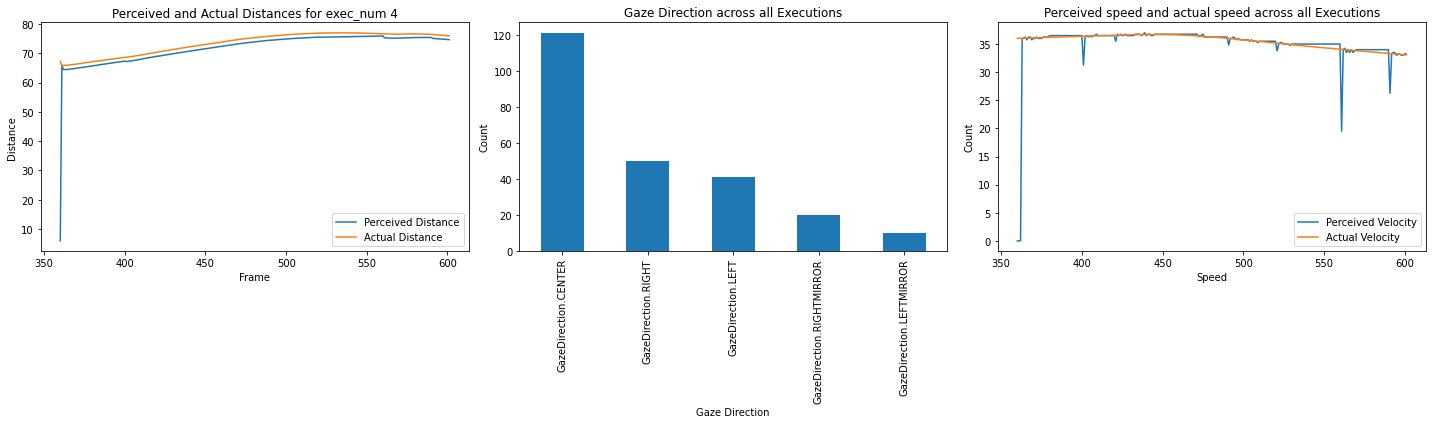

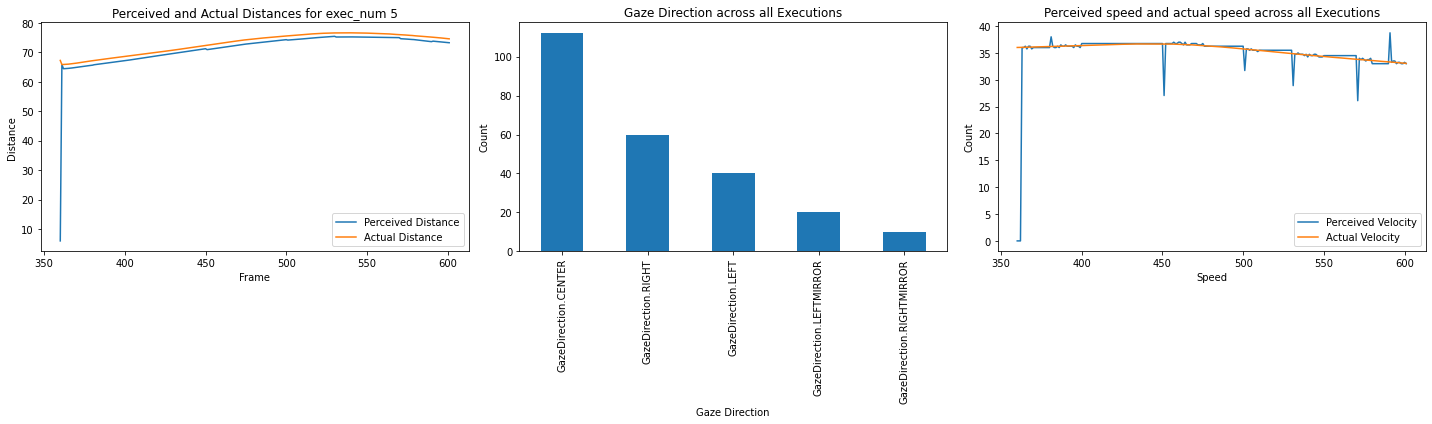

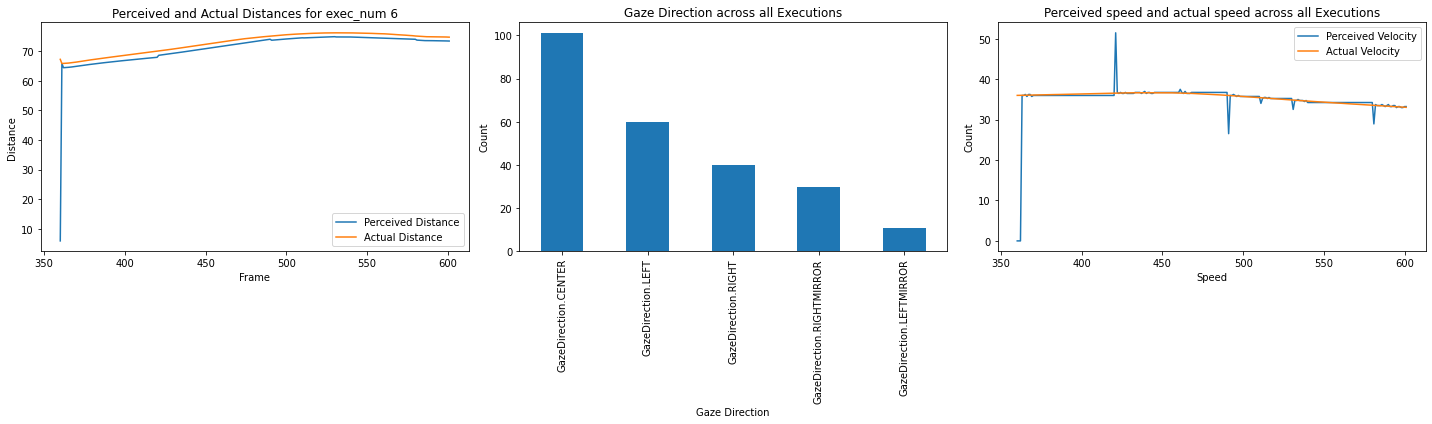

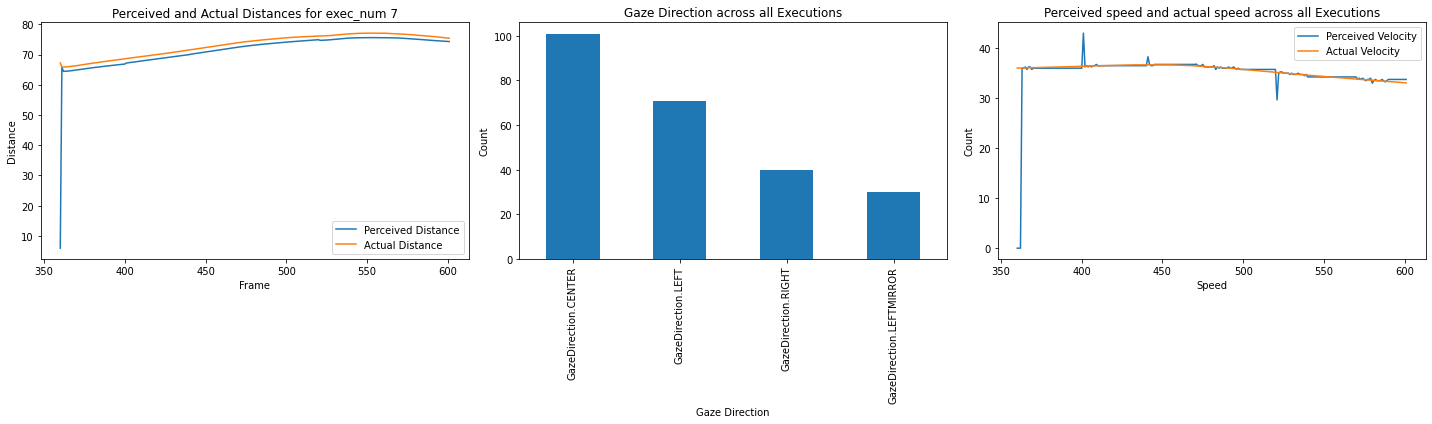

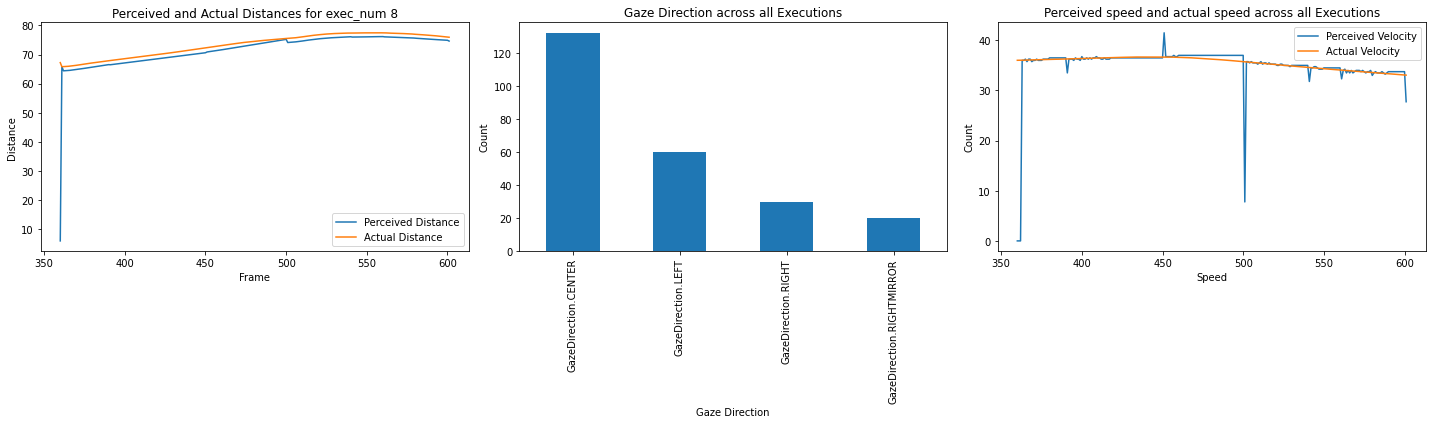

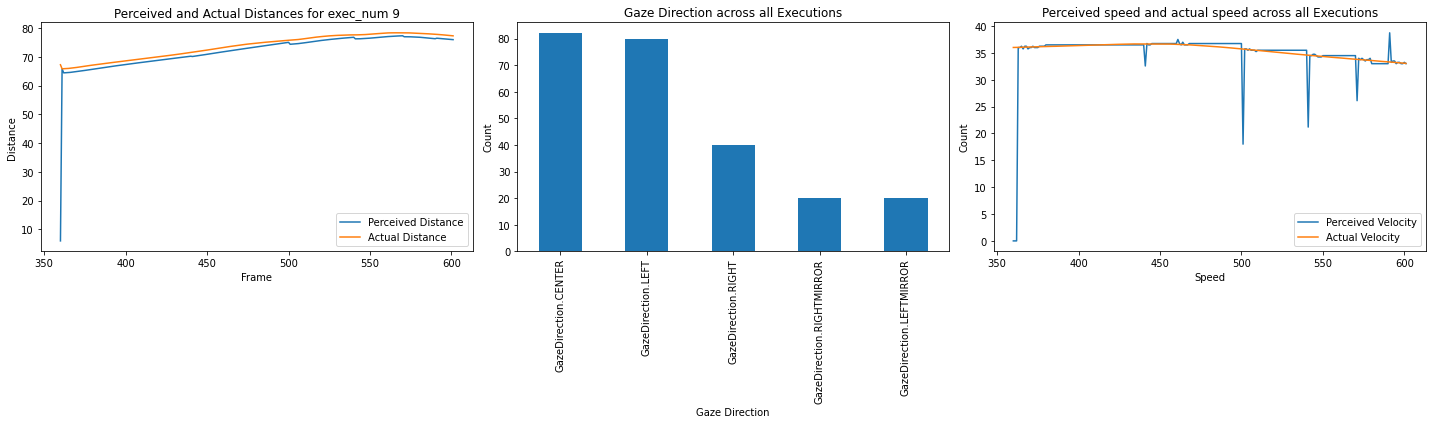

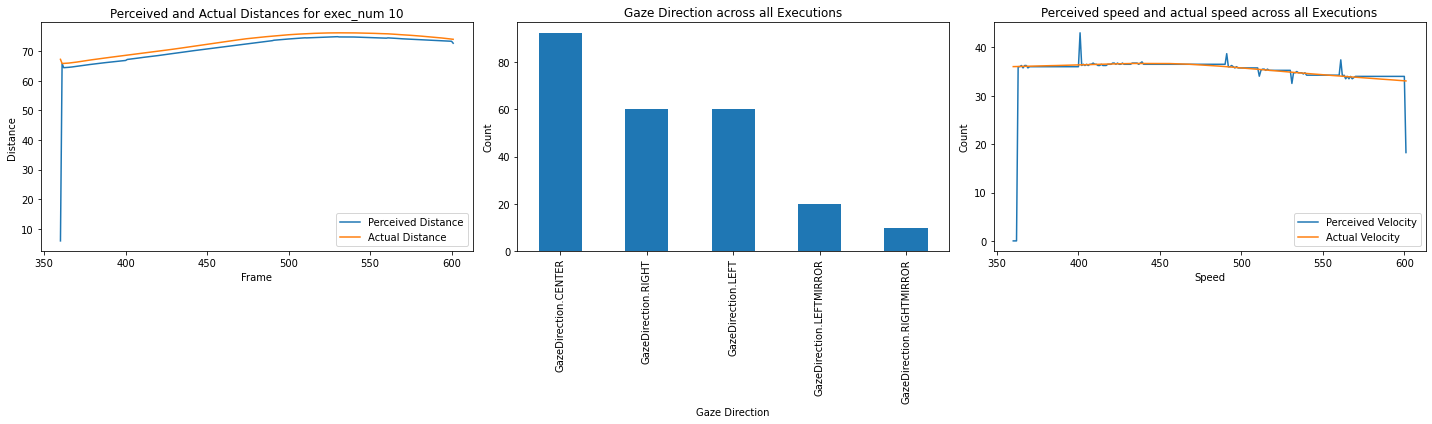

In [6]:
scatter_values(other_cogmod_df)

In [ ]:
# print all unique scenario id 
print(cogmod_df['exec_num'].unique())

In [ ]:
#  nCarFollow 256, filter criteria {'thw_lower_bound': 0, 'thw_upper_bound': 4, 'time_duration': 5, 'distance_threshold': 50}
